In [3]:
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg
using Chemfiles, JUMD
using LinearAlgebra, Statistics
home = "/home/pbarletta/labo/18/lbp/run"
rtdos = "/home/pbarletta/labo/18/lbp/rtdos_log"
plotly()

Plots.PlotlyBackend()

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [4]:
pdb = "4xcp"
# Leo modos
modes_4xcp, evals_4xcp = JUMD.read_ptraj_modes(
    joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4xcp))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol = convert(Array{Float64, 1}, 
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Leo volúmenes originales
vol_avg_4xcp = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_4xcp = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_4xcp = (ndd_out_4xcp .- vol_avg_4xcp) .* evals_4xcp
vgv_4xcp = vgv_4xcp ./ norm(vgv_4xcp);

### Obtiene los aa's del hueco

In [5]:
# VGV cartesiano
xyz_vgv_4xcp = JUMD.tognm(modes_4xcp * vgv_4xcp)

# Pnumber aminoácidos según VGV (aminoácidos de la pared)
cut_4xcp = JUMD.get_pnum(xyz_vgv_4xcp)

# Índices de pnumber aminoácidos
idx_cut_4xcp = sort(sortperm(abs.(xyz_vgv_4xcp), rev = true)[1:cut_4xcp])

# Índices de pnumber aminoácidos en 3aa coordenadas
idx_cut_4xcp_3 = Array{Int64}(undef, length(idx_cut_4xcp) * 3)
for i = 1:length(idx_cut_4xcp)
    idx_cut_4xcp_3[3*i-2] = idx_cut_4xcp[i] * 3 - 2
    idx_cut_4xcp_3[3*i-1] = idx_cut_4xcp[i] * 3 - 1
    idx_cut_4xcp_3[3*i] = idx_cut_4xcp[i] * 3
end

### Obtiene los pnum modos y pnum eigenvals. Cut y enteros

In [8]:
# Pnumber de VGV
vgv_pnu_4xcp = JUMD.get_pnum(vgv_4xcp)

# Pnumber indices
idx_vgv_pnu_4xcp = sortperm(abs.(vgv_4xcp), rev=true)[1:vgv_pnu_4xcp]

# Pnumber modes
modes_pnu_4xcp = modes_4xcp[:, idx_vgv_pnu_4xcp]

# Pnumber eigenvalues
evals_pnu_4xcp = evals_4xcp[idx_vgv_pnu_4xcp];

# Todos los modos recortados según pnumber aminoácidos y normalizo
modes_cut_4xcp = modes_4xcp[idx_cut_4xcp_3, :]
modes_cut_4xcp = mapslices(x -> x ./ norm(x), modes_cut_4xcp, dims = 1)

# Pnum modos recortados según pnumber aminoácidos y normalizo
modes_pnu_cut_4xcp = modes_pnu_4xcp[idx_cut_4xcp_3, :]
modes_pnu_cut_4xcp = mapslices(x -> x ./ norm(x), modes_pnu_cut_4xcp, dims = 1);

### κ

In [10]:
# Colectividad de modos enteros
tmp = eval(:(mapslices(x -> JUMD.get_κ(x),
            mapslices(x -> JUMD.tognm(x), modes_4xcp, dims = 1), dims = 1)))
κ_modes_4xcp = reshape(tmp, length(tmp))

# Colectividad de pnum modos enteros
tmp = eval(:(mapslices(x -> JUMD.get_κ(x),
            mapslices(x -> JUMD.tognm(x), modes_pnu_4xcp, dims = 1), dims = 1)))
κ_modes_pnu_4xcp  = reshape(tmp, length(tmp))

# Colectividad de modos recortados
tmp = mapslices(x -> JUMD.get_κ(x),
    mapslices(x -> JUMD.tognm(x), modes_cut_4xcp, dims = 1), dims = 1)
κ_modes_cut_4xcp  = reshape(tmp, length(tmp))

# Colectividad de pnum modos recortados
tmp = mapslices(x -> JUMD.get_κ(x),
    mapslices(x -> JUMD.tognm(x), modes_pnu_cut_4xcp, dims = 1), dims = 1)
κ_modes_pnu_cut_4xcp = reshape(tmp, length(tmp));

### Pnumber

In [11]:
# Pnumber de modos enteros
tmp = mapslices(x -> JUMD.get_pnum(x),
    mapslices(x -> JUMD.tognm(x), modes_4xcp, dims = 1), dims = 1)
col_modes_4xcp = reshape(tmp, length(tmp)) ./ aa

# Pnumber de pnum modos enteros
tmp = mapslices(x -> JUMD.get_pnum(x),
    mapslices(x -> JUMD.tognm(x), modes_pnu_4xcp, dims = 1), dims = 1)
col_modes_pnu_4xcp = reshape(tmp, length(tmp)) ./ aa

# Pnumber de modos cut
tmp = mapslices(x -> JUMD.get_pnum(x),
    mapslices(x -> JUMD.tognm(x), modes_cut_4xcp, dims = 1), dims = 1)
col_modes_cut_4xcp = reshape(tmp, length(tmp))  ./ cut_4xcp

# Pnumber de pnum modos cut
tmp = mapslices(x -> JUMD.get_pnum(x),
    mapslices(x -> JUMD.tognm(x), modes_pnu_cut_4xcp, dims = 1), dims = 1)
col_modes_pnu_cut_4xcp = reshape(tmp, length(tmp))  ./ cut_4xcp;

## Frecuencia

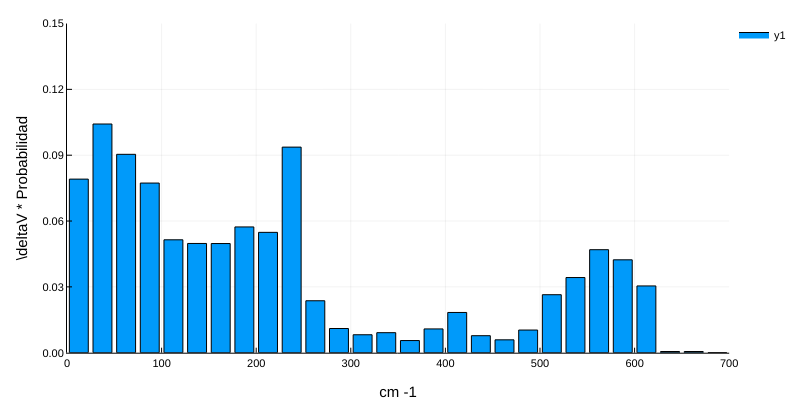

In [13]:
# Los bins van de 0 a la fqcia más alta + 10%
top_evals = maximum(evals_4xcp)
bins_evals = collect(0:25:700)

# Histograma ponderado
Wbins_evals_4xcp, Whis_evals_4xcp = JUMD.WeightedHist(evals_4xcp, bins_evals, abs.(vgv_4xcp), true);

bar(Wbins_evals_4xcp, Whis_evals_4xcp,
    xlims = (0, 700), ylims = (0, .15),
    yaxis = "\\deltaV * Probabilidad", xaxis = "cm -1")

## Colectividad

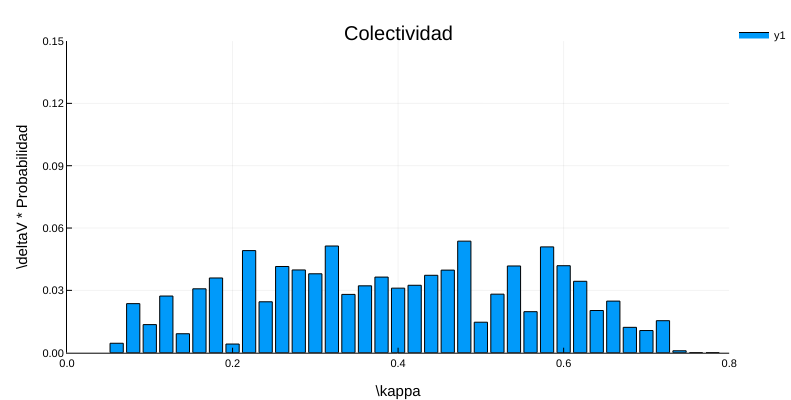

In [14]:
# Los bins van de 0 a la fqcia más alta + 10%
top_κ = maximum(κ_modes_4xcp)
bins_κ = collect(0.05:.02:.8)

# Histograma ponderado
Wbins_κ_4xcp, Whis_κ_4xcp = JUMD.WeightedHist(κ_modes_4xcp, bins_κ, abs.(vgv_4xcp), true, false);

bar(Wbins_κ_4xcp, Whis_κ_4xcp,
    title = "Colectividad",
    xlims = (0, .8), ylims = (0, .15),
    yaxis = "\\deltaV * Probabilidad", xaxis = "\\kappa")

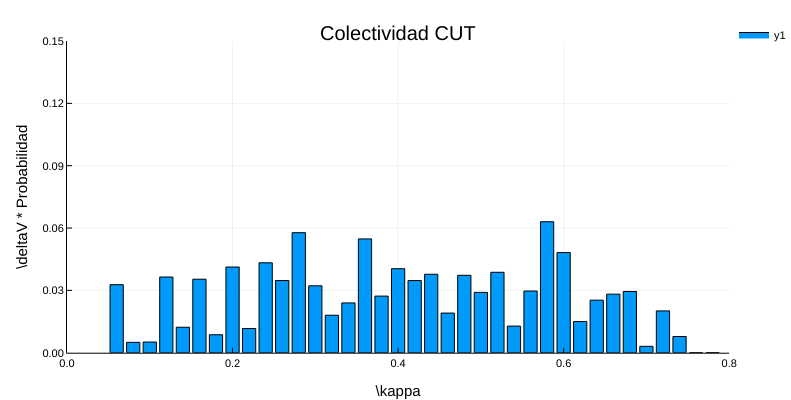

In [15]:
Wbins_κ_cut_4xcp, Whis_κ_cut_4xcp = JUMD.WeightedHist(
    κ_modes_cut_4xcp, bins_κ, abs.(vgv_4xcp), true);

bar(Wbins_κ_cut_4xcp, Whis_κ_cut_4xcp,
    title = "Colectividad CUT",
    xlims = (0, .8), ylims = (0, .15),
    yaxis = "\\deltaV * Probabilidad", xaxis = "\\kappa")

## Colectividad en pnumber

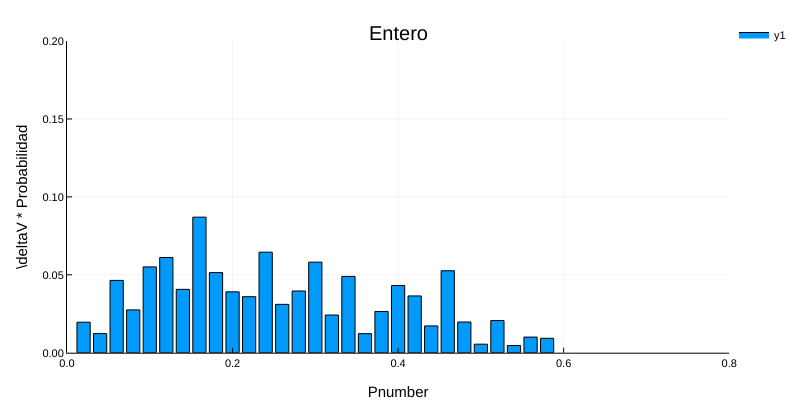

In [16]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_modes_4xcp)
bins_col = collect(0.01:.02:.6)

# Histograma ponderado
Wbins_col_4xcp, Whis_col_4xcp = JUMD.WeightedHist(col_modes_4xcp, bins_col, abs.(vgv_4xcp),
    true, false);

bar(Wbins_col_4xcp, Whis_col_4xcp,
    xlims = (0., .8), ylims = (0, .2),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "Entero")

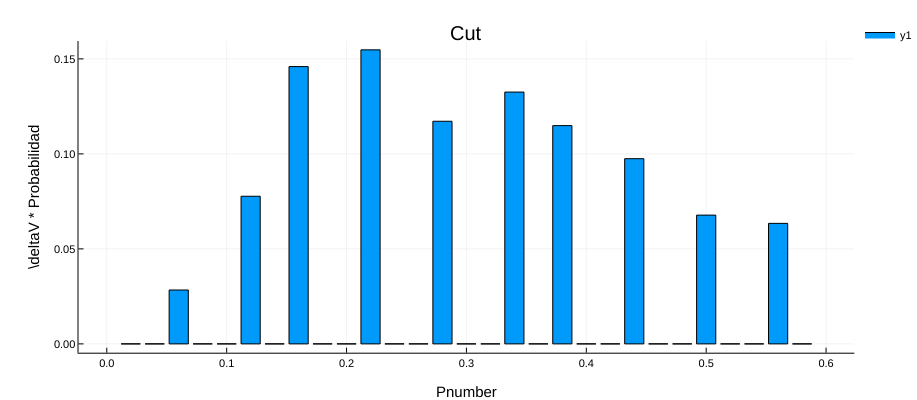

In [13]:
# Uso los bins de arriba
# Histograma ponderado
Wbins_col_cut_4xcp, Whis_col_cut_4xcp = WeightedHist(col_modes_cut_4xcp, bins_col, abs.(vgv_4xcp),
    true, false);

bar(Wbins_col_cut_4xcp, Whis_col_cut_4xcp,
    #xlims = (0., .8), ylims = (0, .2),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "Cut")

## AAs de la pared

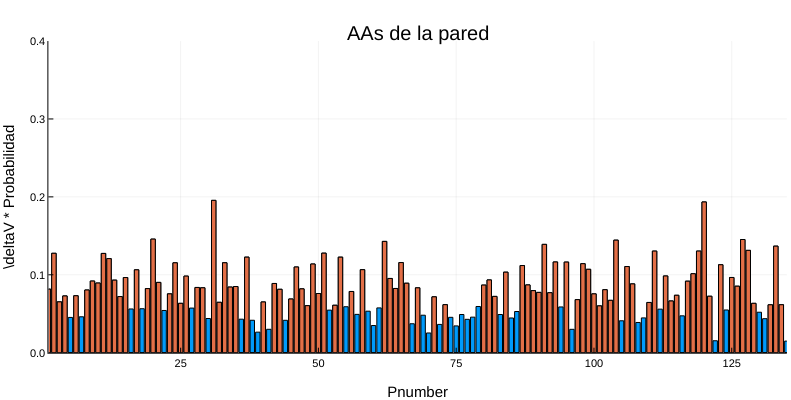

In [17]:
tmp = abs.(xyz_vgv_4xcp)
tmp_ = copy(tmp)
tmp_[tmp_ .< .06] .= 0.;

bar(tmp,
    xlims = (1, 135), ylims = (0, .4),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "AAs de la pared",
    legend = false, size = (750, 400))
bar!(tmp_)

## Volumen de la trayectoria

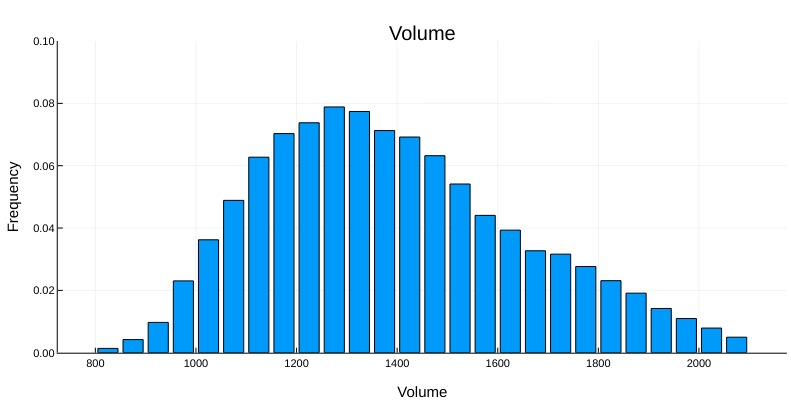

In [18]:
bin_vol = collect(800:50:2100)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Wbins_vol_4xcp, Whis_vol_4xcp = JUMD.WeightedHist(trj_vol, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_4xcp, Whis_vol_4xcp,
    ylims = (0, .1),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    legend = false, size = (750, 400))

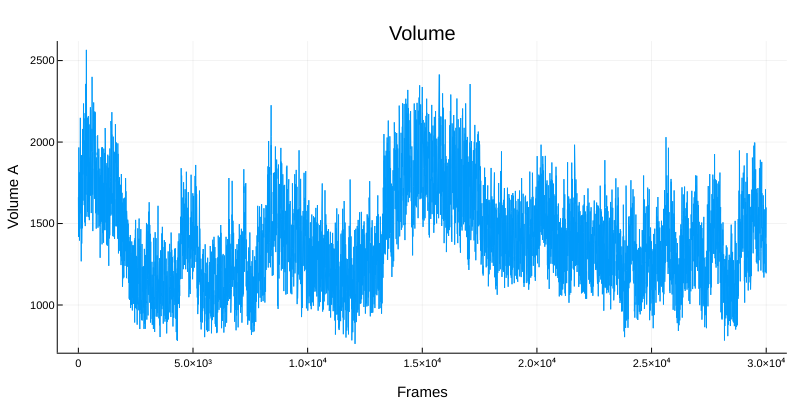

In [19]:
plot(trj_vol,
    yaxis = "Volume A", xaxis = "Frames", title = "Volume",
    xticks = collect(0:5000:5E4),
    legend = false, size = (750, 400))

In [20]:
[ mean(trj_vol) ; std(trj_vol) ]

2-element Array{Float64,1}:
 1396.8782924333334
  266.371461131622 

# Energía

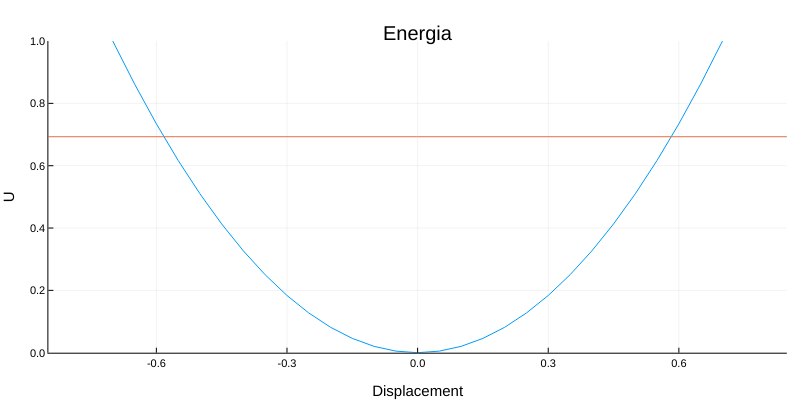

In [23]:
pasos = collect(-.8:.05:.8)
npasos = length(pasos)
RT = 0.693

E_4xcp = Array{Float64,1}(undef, npasos)
i = 0
for d in pasos
    i+=1
    E_4xcp[i] = JUMD.energia_gdte(evals_4xcp, vgv_4xcp, d)
end

plot(pasos, E_4xcp,
    yaxis = "U", xaxis = "Displacement", title = "Energia",
    #xticks = pasos,
    ylims = (0, 1.),
    legend = false, size = (750, 400))
hline!([RT])

# PCA projección
#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

function diff_trj_avg(in_avg_filename::AbstractString, in_trj_filename::AbstractString,
        mask::Array{Int64, 1})
    in_avg_trj = Trajectory(in_avg_filename)
    in_avg_frm = read(in_avg_trj)
    in_avg_top = Topology(in_avg_frm)
    orig_aa = convert(Int64, count_residues(in_avg_top))

    # Get indices de CA
    orig_cas_idx = Array{Int64, 1}(undef, orig_aa)
    k = 0
    for i = 0:convert(Int64, size(in_avg_top)-1)
        if Chemfiles.name(Atom(in_avg_frm, i)) == "CA"
            k+=1
            orig_cas_idx[k] = i + 1
        end
    end
    cas_idx = orig_cas_idx[mask]
    aa = length(cas_idx)
    aa_3 = aa * 3
    # Estas son las coordenadas q voy a usar p/ restar
    avg_xyz = positions(in_avg_frm)[:, cas_idx];

    # Preparo
    in_trj = Trajectory(in_trj_filename)
    nframes = convert(Int64, nsteps(in_trj))
    close(in_trj)
    diff_pdb = Array{Float64, 2}(aa_3, nframes)
    vec_nframes = convert(Array{Int64}, collect(0:nframes/10:nframes));

    # Ahora obtengo las proyecciones
    for j = 1:length(vec_nframes)-1
        in_trj = Trajectory(in_trj_filename)
        for i = vec_nframes[j]:vec_nframes[j+1]-1
            diff_pdb[:, i+1] =
                reshape(positions(read_step(in_trj, i))[:, cas_idx] .- avg_xyz, aa_3)
        end
        close(in_trj)
        println(j)
        GC.gc()
    end

    return diff_pdb
end

dif = diff_trj_avg(joinpath(home, pdb, "pca", string("full_avg_", pdb, ".pdb")),
    joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")),
    collect(10:144))

fid = h5open(joinpath(rtdos, string("diff_", pdb, ".h5")), "w")
write(fid, "dif",dif)
close(fid)

### Obtengo proyecciones de PCA sobre trayectoria

In [13]:
dif = h5read(joinpath(rtdos, string("diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif,  dims = 1)
nframes = size(dif)[2]

prj_1_4xcp = Array{Float64, 1}(undef, nframes)
prj_2_4xcp = Array{Float64, 1}(undef, nframes)
prj_3_4xcp = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 1])
    prj_2_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 2])
    prj_3_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 3])
end

# Smooth
smooth_prj_1_4xcp = [ mean(prj_1_4xcp[i:i+9]) for i = 1:10:length(prj_1_4xcp)-9 ]
smooth_prj_2_4xcp = [ mean(prj_2_4xcp[i:i+9]) for i = 1:10:length(prj_2_4xcp)-9 ]
smooth_prj_3_4xcp = [ mean(prj_3_4xcp[i:i+9]) for i = 1:10:length(prj_3_4xcp)-9 ];

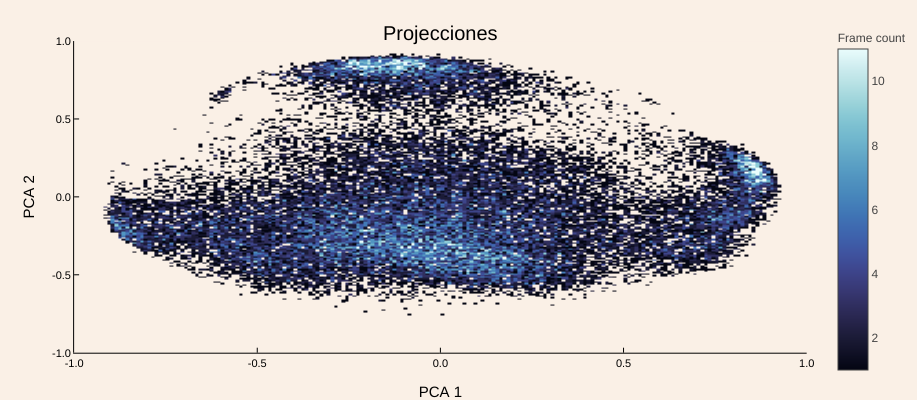

In [18]:
plt_2his = histogram2d(smooth_prj_1_4xcp, smooth_prj_2_4xcp, 
    xlims = (-1., 1.), ylims = (-1., 1.),
    yaxis = "PCA 2", xaxis = "PCA 1", title = "Projecciones",
    clims = (1, 11), colorbar_title = "Frame count",
    nbins = 200, seriescolor = :ice,
    background_color = :linen, foreground_color = :black, grid = false,
    background_color_outside = :linen, background_color_inside = :linen,
    background_color_legend = :linen)

In [ ]:
png(plt_his_vol, joinpath(rtdos, "papel", string("1_plt_his_vol_", pdb)))

savefig(plt_2his, joinpath(rtdos, "papel", string("2_plt_2his_", pdb, ".svg")))